# Detección de clases con aprendizaje supervisado reproducible

## Oier Mentxaka
https://cran.r-project.org/web/packages/arulesCBA/arulesCBA.pdf

### Carga de librerías


In [239]:
library(tidyverse)
library(caret)
library(arulesCBA)
source("Modelos/rCBA.R")
source("Preprocesamiento/utils.R")
source("Preprocesamiento/plots.R")

#### Asignación de la semilla

In [240]:
set.seed(123)

#### Lectura de fichero ya filtrado

In [241]:
data <- read.csv("../data/Statlog_rCBA.csv", header = TRUE, sep = ",")

#### Factorización de las variables

In [242]:
data <- mutate_all(data, as.factor)

#### Separación de train y test

In [243]:
index <- createDataPartition(data$Class, p = 0.7, list = FALSE)

# Split the data
train <- data[index, ]
test <- data[-index, ]

#### Eliminacion de variable a predecir de testing

In [244]:
y_test <- test$Class
test$Class <- NULL

#### Obtención de los Weighs

In [245]:
train_weights <- train$Weights
train$Weights <- NULL
test_weights <- test$Weights
test$Weights <- NULL

#### Grid search

In [246]:
# # Example values for the grid search
# support_values <- seq(0.01, 0.1, by = 0.01)
# confidence_values <- seq(0.01, 0.1, by = 0.01)

# best <- grid_search(train, test, y_test, support_values, confidence_values,train_weights = train_weights, test_weights = test_weights)
# print(best)

#### Selección de variables 

Seleccionadas tras realizar un estudio con grid search

In [247]:
support <- 0.01
confidence <- 0.01

#### Creación del modelo

In [248]:
# Convert the training dataset into transactions
trans <- as(train, "transactions")

# Create rule base with CARs (Classification Association Rules)
cars <- mineCARs(Class ~ ., trans, parameter = list(support = support, confidence = confidence))

# Remove redundant rules
cars <- cars[!is.redundant(cars)]

# Sort the rules by confidence
cars <- sort(cars, by = "conf")

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
       0.01    0.1    1 none FALSE           FALSE       5    0.01      1
 maxlen target  ext
      5  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 7 

set item appearances ...[81 item(s)] done [0.00s].
set transactions ...[81 item(s), 700 transaction(s)] done [0.00s].
sorting and recoding items ... [81 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 5 done [0.18s].
writing ... [346844 rule(s)] done [0.06s].
creating S4 object  ... done [0.06s].


In [249]:
trans

transactions in sparse format with
 700 transactions (rows) and
 81 items (columns)

In [250]:
# Fit the model with weights and the rules
classifier <- CBA_ruleset(Class ~ .,
                           rules = cars,
                           default = uncoveredMajorityClass(Class ~ . , trans, cars),
                           method = "majority",
                           weights = train_weights)

#### Obtención de reglas y transformación

In [251]:
rules <- extract_rules(classifier, test)
head(rules)

,support,confidence,coverage,lift,count,Status.of.existing.checking.account,Duration.in.month,Credit.history,Purpose,Credit.amount,...,Other.installment.plans,Housing,Number.of.existing.credits.at.this.bank,Job,Number.of.people.being.liable.to.provide.maintenance.for,Telephone,Foreign.worker,Gender,Marital.Status,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>
184,0.01000000,1,0.01000000,1.428571,7,NA,NA,NA,retraining,NA,...,NA,own,NA,NA,NA,NA,NA,NA,NA,1
302,0.01142857,1,0.01142857,3.333333,8,NA,NA,no credits/all paid,NA,NA,...,NA,NA,NA,NA,NA,yes~ registered,NA,NA,NA,2
341,0.01571429,1,0.01571429,1.428571,11,NA,NA,NA,NA,NA,...,NA,NA,(2~4],NA,NA,NA,NA,NA,NA,1
379,0.01285714,1,0.01285714,1.428571,9,no checking account,NA,NA,NA,NA,...,NA,NA,(2~4],NA,NA,NA,NA,NA,NA,1
465,0.01142857,1,0.01142857,1.428571,8,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,no,NA,NA,1
466,0.01000000,1,0.01000000,1.428571,7,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,no,NA,NA,1


#### Definición de extracción de reglas activadas

In [252]:
trans_test <- as(test, "transactions")

#### Obtención de predicciones

In [253]:
predictions <- predict(classifier, trans_test, weights = test_weights)

#### Matriz de confusión

In [254]:
confusion_matrix <- confusion_matrix(predictions, y_test)

[1] "Confusion Matrix:"
           actual_labels
predictions   1   2
          1 151  21
          2  59  69


#### Precisión del modelo

In [255]:
# Calculate accuracy
accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
print(paste("Accuracy:", accuracy))

[1] "Accuracy: 0.733333333333333"


#### Resultados por nsplits

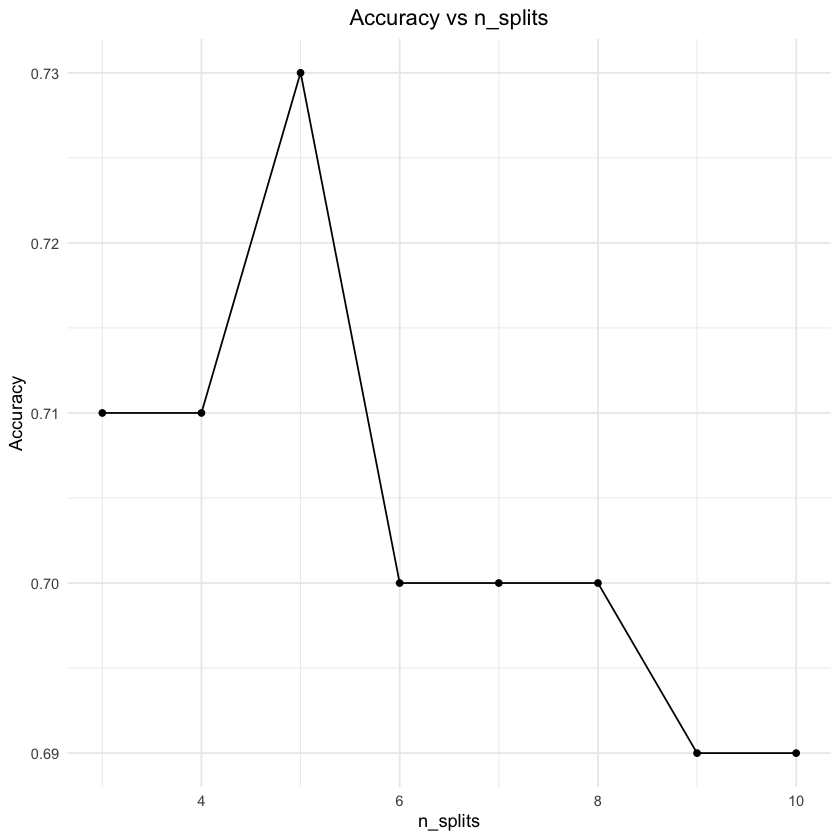

In [256]:
accuracies <- c(0.71, 0.71, 0.73, 0.7, 0.7, 0.7, 0.69, 0.69)
n_splits <- c(3, 4, 5, 6, 7, 8, 9, 10)

# plot the data
ggplot(data.frame(n_splits, accuracies), aes(x = n_splits, y = accuracies)) +
  geom_line() +
  geom_point() +
  labs(title = "Accuracy vs n_splits",
       x = "n_splits",
       y = "Accuracy") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))